# Estimate clade frequencies through time

This tutorial shows how to use Augur's frequency estimation tools to estimate the frequencies of SARS-CoV-2 clades through time and use that information to identify clades that have risen in frequency rapidly.

In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Get the data

Define the URLs to a phylogeny of a global Nextstrain analysis of SARS-CoV-2 and the precalculated frequencies for each strain in that phylogeny.

In [2]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
frequencies_url = "https://data.nextstrain.org/ncov_global_tip-frequencies.json"

Download precalculated frequencies.

In [3]:
frequencies = requests.get(frequencies_url).json()

Frequencies are stored by strain name.

In [4]:
print(list(frequencies.keys())[:5])

['Afghanistan/IMB07964/2020', 'Afghanistan/IMB07966/2020', 'Afghanistan/IMB15483/2021', 'Afghanistan/IMB15484/2021', 'Afghanistan/IMB15486/2021']


Each strain has a list of frequencies at multiple timepoints from the global analysis.

In [5]:
print(frequencies[list(frequencies.keys())[0]])
# print(frequencies["Afghanistan/IMB07964/2020"])

{'frequencies': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 4e-06, 1.4e-05, 4.4e-05, 0.00014, 0.000392, 0.000942, 0.002006, 0.003429, 0.004937, 0.00601, 0.006166, 0.005451, 0.004102, 0.002684, 0.001536, 0.000735, 0.000321, 0.000121, 3.9e-05, 1.2e-05, 3e-06, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In addition to strain-specific data, the frequencies data also include the array of timepoints (or "pivots") at which frequencies were originally estimated for each strain. Each position in the array of pivots corresponds to a position in each strain's frequencies array.

In [6]:
print(frequencies["pivots"][:5])

[2020.011, 2020.0301, 2020.0493, 2020.0684, 2020.0861]


We can also learn how these frequencies were originally generated.

In [7]:
print(frequencies["generated_by"])

{'program': 'augur', 'version': '12.0.0'}


Let's export the pivots into their own variable, removing them from the main data structure. We convert them to a numpy array to simplify math and plotting operations later.

In [8]:
pivots = np.array(frequencies.pop("pivots"))

In [9]:
print(pivots)

[2020.011  2020.0301 2020.0493 2020.0684 2020.0861 2020.1052 2020.1244
 2020.1436 2020.1667 2020.1858 2020.205  2020.2242 2020.2433 2020.261
 2020.2801 2020.2993 2020.3184 2020.3388 2020.358  2020.3771 2020.3963
 2020.4155 2020.4331 2020.4523 2020.4714 2020.4906 2020.511  2020.5301
 2020.5493 2020.5684 2020.5861 2020.6052 2020.6244 2020.6436 2020.6627
 2020.6804 2020.6995 2020.7187 2020.7379 2020.7582 2020.7774 2020.7965
 2020.8157 2020.8333 2020.8525 2020.8717 2020.8908 2020.91   2020.9304
 2020.9495 2020.9687 2020.9879 2021.0055 2021.0246 2021.0438 2021.063
 2021.0821 2021.0998 2021.1189 2021.1381 2021.1573 2021.1831 2021.2023
 2021.2214 2021.2406 2021.2582]


Let's convert the dictionary of lists to numpy arrays, too.

In [10]:
frequency_arrays = {
    strain: np.array(strain_frequencies["frequencies"])
    for strain, strain_frequencies in frequencies.items()
    if "frequencies" in strain_frequencies
}

In [11]:
print(frequency_arrays['Afghanistan/IMB07958/2020'])

KeyError: 'Afghanistan/IMB07958/2020'

## Plot strain frequencies through time

Now, we can plot the frequency of an individual strain over time. This view shows us that each strain's frequencies through time are represented by a normal distribution. This representation is a feature of [the kernel density estimation (KDE) method of frequency estimation in Augur](https://docs.nextstrain.org/projects/augur/en/stable/usage/cli/frequencies.html).

Text(0, 0.5, 'Frequency')

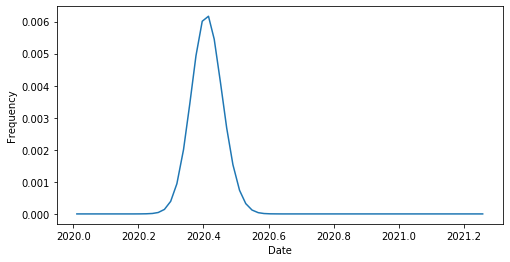

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(
    pivots,
    frequency_arrays[list(frequencies.keys())[0]]
)
# ax.plot(
#     pivots,
#     frequency_arrays["Afghanistan/IMB07964/2020"]
# )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

We can also plot the frequencies of all strains over time at once. This view shows us all of the overlapping normal distributions for each strain. It also shows us the noise (or uncertainty) in frequency estimates at the beginning of 2020 when relatively few SARS-CoV-2 strains had been sampled.

Text(0, 0.5, 'Frequency')

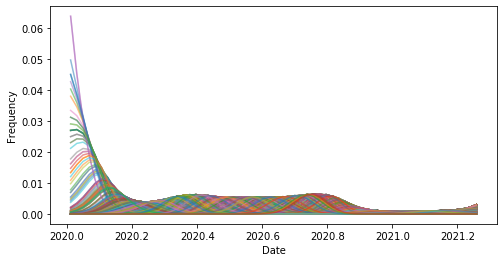

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for strain, strain_frequencies in frequency_arrays.items():
    ax.plot(
        pivots,
        strain_frequencies,
        alpha=0.5
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

## Estimate clade frequencies through time

In practice, we care about the growth or decline of groups of strains that all share the same mutation(s), or _clades_. Clades are also represented as internal or ancestral nodes of a phylogeny. To calculate the frequencies of clades through time, we need to know which strains belong to each clade which is information provided by the original phylogeny. So, let's download the phylogenetic tree of the strains that we've loaded frequencies for.

In [14]:
tree_json = requests.get(tree_url).json()

On [nextstrain.org](https://nextstrain.org), the tree is a JSON file, but to work with the tree in Python, we need to convert the JSON to a BioPython tree data structure.

In [15]:
tree = json_to_tree(tree_json)

Every inferred ancestral node and observed strain in the tree is represented as a "clade" object with zero or more descendants. This means the root of the tree is a clade, too. Ancestral nodes get their own arbitrary names, so we can perform operations on specific nodes.

In [16]:
print(repr(tree))

Clade(branch_length=0, name='NODE_0003992')


Before we can inspect the frequency of clades over time, we need to calculate the frequency of each clade from its child strain frequencies. The frequency of any clade at a given time is the sum of its child strain frequencies at that time. We'll calculate these clade frequencies in a bottom-up approach, working from each tip up to the root of the tree. This is also known as a [postorder tree traversal](https://en.wikipedia.org/wiki/Tree_traversal#Post-order,_LRN).

In [17]:
for node in tree.find_clades(order="postorder"):
    if node.is_terminal():
        # We already know the frequencies of each terminal node, so
        # store those frequencies with the corresponding node of the tree.
        node.frequencies = frequency_arrays[node.name]
    else:
        # For each internal node, sum the frequencies of its immediate
        # children. Since we are walking through the tree from the bottom
        # up, each child node will always have frequencies calculated
        # before its parent node.
        node.frequencies = np.array([
            child.frequencies
            for child in node.clades
        ]).sum(axis=0)

The root node of the tree should always be at 100% frequency. We can see that this is generally true, within the bounds of some rounding error.

In [32]:
tree.root.frequencies

array([1.000001, 0.999976, 0.999992, 0.999988, 1.000006, 1.000002,
       0.999984, 0.999995, 0.999993, 1.000007, 0.999979, 1.000007,
       1.000003, 0.999979, 0.999979, 0.999984, 0.999962, 0.999983,
       0.999953, 1.000006, 1.000008, 0.99996 , 0.99999 , 1.000022,
       0.999964, 0.999966, 1.000004, 1.000007, 1.000015, 0.999969,
       0.999994, 0.999968, 0.999974, 0.999979, 0.999962, 0.999912,
       0.999957, 0.999999, 1.000012, 0.99999 , 0.999854, 0.999941,
       0.999937, 0.999995, 0.999904, 0.999944, 0.99991 , 0.999979,
       0.99992 , 0.999943, 1.000061, 0.999974, 0.999973, 0.999882,
       1.000104, 0.999916, 0.999869, 1.000042, 0.999852, 0.999916,
       1.000003, 1.000119])

Now, we can investigate the frequency of different clades through time. In addition to strain names, each node of the tree also carries annotations like clade membership. We can use these annotations to identify the most ancestral node for each major clade. Then we can plot the frequencies of these clades through time.

In [18]:
clade_nodes_by_name = {}
for node in tree.find_clades(terminal=False):
    if "clade_membership" in node.node_attrs:
        clade_name = node.node_attrs["clade_membership"]["value"]

        if clade_name not in clade_nodes_by_name:
            clade_nodes_by_name[clade_name] = node

From the list below, we see that we found all major clades annotated in the tree.

In [19]:
print(clade_nodes_by_name.keys())

dict_keys(['19A', '19B', '20A', '20E (EU1)', '20C', '20G', '20H/501Y.V2', '20B', '20D', '20J/501Y.V3', '20F', '20I/501Y.V1'])


Let's plot the frequency of the clade 20A through time.

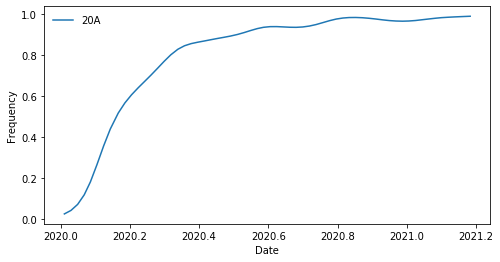

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(
    pivots,
    clade_nodes_by_name["20A"].frequencies,
    label="20A"
)

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(frameon=False)

Now that we know what to expect, we can plot all clades at once.

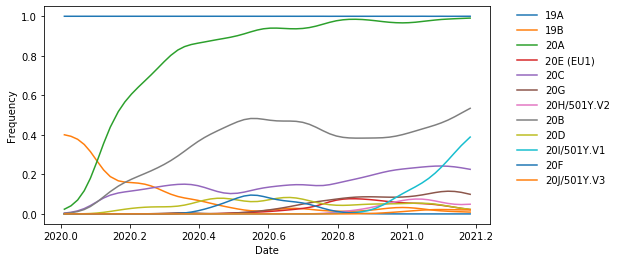

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in clade_nodes_by_name.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

We can also investigate the frequencies of clades that carry a specific mutation. As an example, let's find all clades that carry the S:484K mutation. Each node in the tree also carries information about the mutations that occurred on the branch leading to that node.

In [46]:
tree.root.clades[-1].branch_attrs

{'mutations': {}}

Use this branch-specific information to find all ancestral nodes with a S:484K mutation on their preceding branch.

In [47]:
clade_nodes_with_484K_by_name = {}
for node in tree.find_clades(terminal=False):
    if (hasattr(node, "branch_attrs") and
        "mutations" in node.branch_attrs and 
        "S" in node.branch_attrs["mutations"] and 
        any([mutation.endswith("484K") for mutation in node.branch_attrs["mutations"]["S"]])):
        if node.name not in clade_nodes_by_name:
            clade_nodes_with_484K_by_name[node.name] = node

We found multiple clades with a S:484K mutation. Since these clades don't necessarily have official names, we will use their internal names for now. In practice, we may want to name these clades after the specific mutations on the branch leading to each clade.

In [48]:
print(clade_nodes_with_484K_by_name.keys())

dict_keys(['NODE_0000610', 'NODE_0000881', 'NODE_0000871', 'NODE_0001119', 'NODE_0001363', 'NODE_0002520', 'NODE_0003571', 'NODE_0003006', 'NODE_0003606', 'NODE_0003639'])


Now, we can plot the frequencies of those clades.

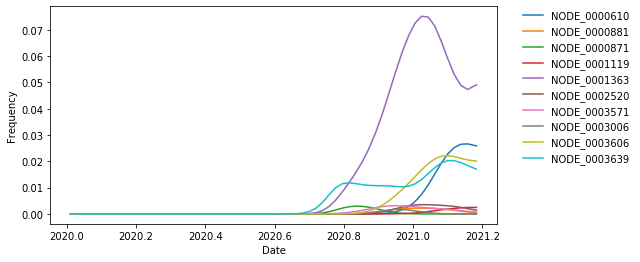

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in clade_nodes_with_484K_by_name.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

## Calculate change in frequency over time per clade

In addition to observing the frequencies of clades through time, we also want to calculate much each clade has changed in frequency recently. This measure is an indication of growth or decline. Rapidly growing clades may indicate potential variants of concern.

We calculate frequencies at weekly intervals, such that "pivots" are spaced by one week. To find the change in frequency of clades over the last month, we need to compare the most recent frequency of each clade to the frequency four pivots previous. We'll calculate this change in frequency (or "delta frequency") for each major clade.

In [50]:
delta_frequencies = []
for clade_name, clade_node in clade_nodes_by_name.items():
    delta_frequency = clade_node.frequencies[-1] - clade_node.frequencies[-5]
    delta_frequencies.append({
        "clade_name": clade_name,
        "delta_frequency": delta_frequency
    })

Convert the delta frequencies to a pandas DataFrame for easily manipulation and visualization.

In [51]:
delta_frequencies_df = pd.DataFrame(delta_frequencies)

List clades by change in frequency in descending order.

In [52]:
delta_frequencies_df.sort_values("delta_frequency", ascending=False)

,clade_name,delta_frequency
9,20I/501Y.V1,0.152523
7,20B,0.073556
2,20A,0.006957
0,19A,0.000077
10,20F,0.000000
11,20J/501Y.V3,-0.002099
1,19B,-0.006255
6,20H/501Y.V2,-0.010157
5,20G,-0.013409
4,20C,-0.016833
